##  Probit models to forecast binary outcomes such as recessions
<div style="text-align: right"> Fogli Alessandro </div>
<div style="text-align: right"> ID 231273 </div>
<div style="text-align: right"> Project #3 </div>

### Install packages

In [15]:
import scipy.stats as si
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import pandas_datareader as pdr
import datetime
from IPython.display import display, HTML
import datetime as dt
import dataframe_image as dfi
import getFamaFrenchFactors as gff
import quandl
from fredapi import Fred
import config
fred = Fred(api_key= config.fred_api)
QUANDL_KEY = config.quandl_key
quandl.ApiConfig.api_key = QUANDL_KEY
from scipy import stats
from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.discrete.discrete_model import Probit
import statsmodels.formula.api as smf

### Data (all quarterly)

Get data of difference in yields between 10 year and 3 months U.S. Treasuries

In [16]:
t10y = fred.get_series('DGS10', observation_start="1962-01-02",observation_end= "2021-12-31",frequency='q')
t3mo = fred.get_series('TB3MS', observation_start="1962-01-02",observation_end= "2021-12-31",frequency='q')
term = t10y-t3mo
term = term.dropna()
#term = term.tolist()
term = term.to_frame().rename(columns={0: 'term'})
#240

Get data of Federal Funds Rate

In [17]:
funds_rate = fred.get_series('FEDFUNDS', observation_start="1962-01-02", observation_end= "2021-12-31" ,frequency='q')
funds_rate = funds_rate.to_frame().rename(columns={0: 'funds_rate'})

Get data of GDP Growth

In [18]:
gdp = fred.get_series('GDP', observation_start="1962-01-02", observation_end= "2021-12-31",frequency='q', units='pch')
#240 miss first quarter 2022
gdp = gdp.to_frame().rename(columns={0: 'gdp'})

NBER based Recession Indicators for the United States

In [19]:
nber = fred.get_series('USREC', observation_start="1962-01-01", observation_end= "2021-12-31" ,frequency='q')
nber = nber.astype(int)
#nber = nber.tolist()
#term.isna().sum().sum()
#count = np.isinf(term).values.sum()
nber = nber.to_frame().rename(columns={0: 'nber'})

Load data of S&P500 Futures - Jun 2022 expiring date

In [20]:
sp500_futures = pd.read_csv('S&P 500 Futures Historical Data.csv', index_col = 0)
sp500_futures.index = pd.to_datetime(sp500_futures.index, format= '%b %y') # date index transforming
sp500_futures.index = sp500_futures.index + pd.offsets.MonthEnd()
sp500_futures_rtn = sp500_futures['Change %']
sp500_futures_rtn= sp500_futures_rtn.str.replace('%','') # remove str % from value
sp500_futures_rtn = pd.to_numeric(sp500_futures_rtn, errors='coerce')
sp500_futures_rtn.fillna(0, inplace=True)
sp500_futures_rtn = sp500_futures_rtn.iloc[::-1]
sp500_futures_rtn = sp500_futures_rtn.drop(sp500_futures_rtn.tail(1).index,inplace=True) # adjusting size to match stocks month
print(sp500_futures_rtn)

None


Get data of S&P500

In [21]:
sp500 = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH", start_date='1961-10-01', end_date='2021-12-31', collapse="monthly",authtoken="WcG92wpxYRRUQmyNxVxZ")
sp500_quarter_rtn = sp500.resample("3M").mean()
sp500_quarter_rtn = sp500_quarter_rtn.pct_change()
sp500_quarter_rtn = sp500_quarter_rtn.dropna()
sp500_quarter_rtn.drop(sp500_quarter_rtn.tail(1).index,inplace=True)
sp500_quarter_rtn = sp500_quarter_rtn.apply(lambda x: x* 100)
sp500_quarter_rtn = sp500_quarter_rtn['Value'].tolist()

### Probit model

A probit regression is a version of the generalized linear model used to model dichotomous outcome variables. It uses the inverse standard normal distribution as a linear combination of the predictors. The binary outcome variable Y is assumed to have a Bernoulli distribution with parameter p (where the success probability is p∈(0,1). Hence, the probit link function is:
$$ probit(Y) = \sum_{k=0}^n \beta_{k} x_{ik} $$

The Probit model assumes that the firm’s probability of recession has a cumulative standard-normal distribution, rather than a logistic distribution. However, by multiplying the results of the logistic distribution by an appropriate coefficient the distribution of the Probit model can be obtained.

Implementing Probit model with only Term as explanatory variable

In [22]:
term_nber = nber.join(term['term'])
all_factors =  term.join(funds_rate['funds_rate']).join(gdp['gdp'])
all_factors['market'] = sp500_quarter_rtn

In [23]:
def prob_model(valx, valy, par, shiftvalue): #valx explanatory / valy dependent variable (always nber) / par is what result you want
    
    valx = valx.shift(shiftvalue) #switch lag and drop first val (Nan) of independent variable
 
    valx = valx.iloc[shiftvalue: , :] #drop firs row of dependent var
    valy = valy.iloc[shiftvalue: , :]
    X =  valx #factors
    y =  valy #nber
    X = sm.add_constant(X)
    model = Probit(y, X).fit()
    match par:
        case 'rsquared':
            return model.prsquared
        case 'values':
            return model.fittedvalues
        case 'pvalues':
            return model.pvalues[1:].values
        case 'alpha':
            return model.params['const']
        case 'beta':
            return model.params[1:].values # get all betas without alpha

In [24]:
def fill(valx, valy):

    results = pd.DataFrame({ 
                    "Quarter ahead": [],               
                    "observations": [],
                    "Beta": [],
                    "Alpha": [],
                    "R-sq": [],
                    "p-val term": [],
                    
                })
    for i in range(1,13):
        observation = len(prob_model(valx, valy, 'values',i))
        beta = prob_model(valx, valy, 'beta',i)
        pval = prob_model(valx, valy, 'pvalues',i)
        alpha = prob_model(valx, valy, 'alpha',i)
        rsq = prob_model(valx, valy, 'rsquared',i)
        ahead = i

        results.loc[i-1] = pd.Series({'Quarter ahead': ahead, 'observations': observation, 'Beta': beta[0], 'Alpha': alpha,'R-sq': rsq, 'p-val term': pval[0]}) #'Alpha': alpha,
        
   
    results.set_index('Quarter ahead', inplace=True)
    global greater

    display(HTML(results.to_html(classes='table table-stripde')))
    results['R-sq'] = pd.to_numeric(results['R-sq'])
    greater = results[['R-sq']].idxmax()
    #dfi.export(results, 'single_factor_table.png')
fill(term, nber)


Optimization terminated successfully.
         Current function value: 0.350905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.350905
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315908
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.315908
  

,observations,Beta,Alpha,R-sq,p-val term
Quarter ahead,,,,,
1.0,239.0,-0.264434,-0.827559,0.050540,3.630060e-03
2.0,238.0,-0.487584,-0.616952,0.147561,3.301870e-06
3.0,237.0,-0.683002,-0.486061,0.242320,3.039846e-08
4.0,236.0,-0.728607,-0.461981,0.261286,1.816275e-08
5.0,235.0,-0.782195,-0.437563,0.275321,2.499574e-08
6.0,234.0,-0.668358,-0.487791,0.224262,1.438691e-07
7.0,233.0,-0.504975,-0.590083,0.149727,3.937937e-06
8.0,232.0,-0.385322,-0.684722,0.096250,1.093219e-04
9.0,231.0,-0.315776,-0.747504,0.067263,9.644935e-04


In [25]:
def normsdist(z):
    z = si.norm.cdf(z,0.0,1.0)
    return (z)

Optimization terminated successfully.
         Current function value: 0.270779
         Iterations 7


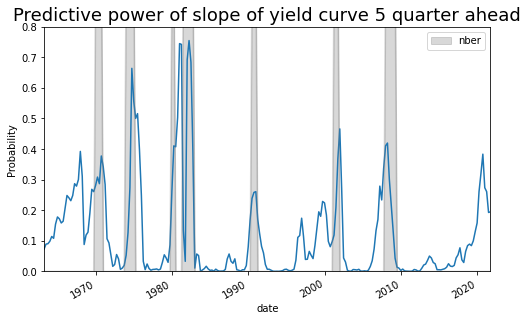

In [26]:
def plot_val(valx, valy, shiftvalue ):

    values = prob_model(valx, valy, 'values', shiftvalue)
    valy = valy.iloc[shiftvalue: , :]
    bars = valy.reset_index().rename(columns={'index': 'date'})
    data= valy.reset_index().rename(columns={'index': 'date'})
    data['prob of recession'] = normsdist(values)

    fig, ax = plt.subplots(figsize=(8,5))
    ax.plot(data['date'],data['prob of recession'])
    bars.plot.area(ax=ax, figsize=(8, 5), x='date', alpha=0.3, color="gray")
  
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_title('Predictive power of slope of yield curve {} quarter ahead'.format(shiftvalue), size=18)
    plt.xlim("1963-04-01", "2021-10-01")
    plt.ylim(0,0.8)
    
plot_val(term, nber, int(greater))

In [27]:
def fill2(valx, valy):

    results = pd.DataFrame({ 
                    "Quarter ahead": [],               
                    "observations": [],
                    "Beta term": [], "p-val term": [],
                    "Beta funds_rate": [], "p-val funds_rate": [],
                    "Beta gdp": [], "p-val gdp": [],
                    "Beta market": [], "p-val market": [],
                    "Alpha": [],
                    "R-sq": [],
                    
                    
                })
    for i in range(1,13):
        observation = len(prob_model(valx, valy, 'values',i))
        beta = prob_model(valx, valy, 'beta',i)
        pval = prob_model(valx, valy, 'pvalues',i)
        alpha = prob_model(valx, valy, 'alpha',i)
        rsq = prob_model(valx, valy, 'rsquared',i)
        ahead = i

        results.loc[i-1] = pd.Series({
                    'Quarter ahead': ahead, 
                    'observations': observation, 
                    'Beta term': beta[0], "p-val term": pval[0],
                    "Beta funds_rate": beta[1], "p-val funds_rate": pval[1],
                    "Beta gdp": beta[2], "p-val gdp": pval[2],
                    "Beta market": beta[3], "p-val market": pval[3],
                    'Alpha': alpha,
                    'R-sq': rsq, 
                })
   
    results.set_index('Quarter ahead', inplace=True)
    global greater2

    display(HTML(results.to_html(classes='table table-stripde')))
    results['R-sq'] = pd.to_numeric(results['R-sq'])
    greater2 = results[['R-sq']].idxmax()
    #dfi.export(results, 'multi_factor_table.png')
fill2(all_factors, nber)

Optimization terminated successfully.
         Current function value: 0.206824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.206824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231900
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.231900
  

,observations,Beta term,p-val term,Beta funds_rate,p-val funds_rate,Beta gdp,p-val gdp,Beta market,p-val market,Alpha,R-sq
Quarter ahead,,,,,,,,,,,
1.0,239.0,-0.072990,0.547969,0.209541,0.000003,-0.243903,0.010239,-0.112910,0.000002,-2.129558,0.440387
2.0,238.0,-0.313665,0.012519,0.176195,0.000025,-0.199186,0.035398,-0.071570,0.000682,-1.633266,0.374246
3.0,237.0,-0.500695,0.000224,0.143715,0.000388,-0.144052,0.141357,-0.044009,0.043443,-1.320739,0.363914
4.0,236.0,-0.546606,0.000055,0.118050,0.002706,-0.037954,0.724007,-0.016975,0.441098,-1.277780,0.324381
5.0,235.0,-0.615455,0.000029,0.110817,0.007051,-0.003473,0.976759,0.031202,0.200508,-1.318471,0.327009
6.0,234.0,-0.560031,0.000066,0.085661,0.038387,0.151672,0.294540,0.043151,0.077801,-1.474046,0.286144
7.0,233.0,-0.469180,0.000413,0.049227,0.226557,0.374501,0.006234,0.048882,0.046826,-1.730264,0.247423
8.0,232.0,-0.329146,0.004470,0.022651,0.553546,0.379431,0.003426,0.017705,0.420839,-1.612878,0.170903
9.0,231.0,-0.266969,0.014144,0.025264,0.488913,0.166716,0.190025,0.020880,0.307253,-1.288957,0.093531


Optimization terminated successfully.
         Current function value: 0.207584
         Iterations 7


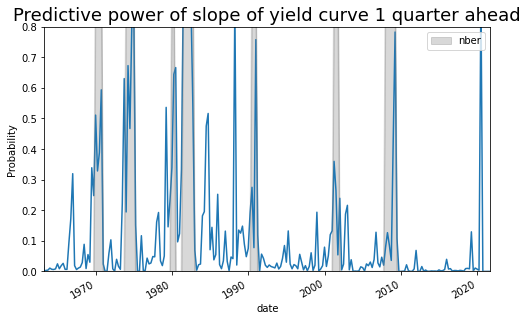

In [28]:
all_factors2 = all_factors.drop(['term'], axis=1)
plot_val(all_factors2, nber, int(greater2))